# Sentiment analysis review base( Classification) 

# Import Libraries

In [ ]:
!pip install pyLDAvis




In [59]:
import gzip
import re
import pickle
from tqdm import tqdm
import pandas as pd
import nltk
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import ConfusionMatrixDisplay
from collections import Counter  # to get the most common words in a string 
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import resample
from sklearn.decomposition import LatentDirichletAllocation
import requests
import json   
from PIL import Image
from skimage import io
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from transformers import DistilBertTokenizerFast
from collections import Counter  # to get the most common words in a string 



vocab = Counter()
sns.reset_defaults()
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## download dataset 
run just once 

In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
import requests
url = 'http://snap.stanford.edu/data/amazon/Books.txt.gz'
r = requests.get(url, allow_redirects=True)
open('/content/drive/MyDrive/NLP/Books.txt.gz', 'wb').write(r.content)

In [ ]:
def parse(filename):
  f = gzip.open(filename, 'r')
  entry = {}
  for l in f:
    l = l.decode("ascii")
    l = l.strip()
    colonPos = l.find(':')
    if colonPos == -1:
      yield entry
      entry = {}
      continue
    eName = l[:colonPos]
    rest = l[colonPos+2:]
    entry[eName] = rest
  yield entry

In [ ]:
dict = []
reviews_num = 0
for e in tqdm(parse("Books.txt.gz")):
  dict.append(e)
  reviews_num += 1
  if reviews_num==1000000:
    break

In [ ]:
df=pd.DataFrame(dict)
df.to_csv('/content/drive/MyDrive/Data_set/recommender_system/user_rating.csv')

In [ ]:
dict=None
df=None

# Load the data

In [5]:
df=pd.read_csv('/content/drive/MyDrive/Data_set/recommender_system/user_rating.csv')
df.head()

,Unnamed: 0,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,0,1882931173,Its Only Art If Its Well Hung!,unknown,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,1,0826414346,Dr. Seuss: American Icon,unknown,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,2,0826414346,Dr. Seuss: American Icon,unknown,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,3,0826414346,Dr. Seuss: American Icon,unknown,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,4,0826414346,Dr. Seuss: American Icon,unknown,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


# Data Preparation

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Unnamed: 0          1000000 non-null  int64  
 1   product/productId   1000000 non-null  object 
 2   product/title       999993 non-null   object 
 3   product/price       1000000 non-null  object 
 4   review/userId       1000000 non-null  object 
 5   review/profileName  999978 non-null   object 
 6   review/helpfulness  1000000 non-null  object 
 7   review/score        1000000 non-null  float64
 8   review/time         1000000 non-null  int64  
 9   review/summary      999991 non-null   object 
 10  review/text         999999 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 83.9+ MB


In [7]:
df['product/title'].value_counts().sum()

999993

## Remove extra columns

In [8]:
df = df.drop(['Unnamed: 0','product/productId', 'product/price', 'review/profileName', 'review/time','review/summary','review/helpfulness'], axis=1)

In [9]:
df.head()

,product/title,review/userId,review/score,review/text
0,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Philip Nel - Dr. Seuss: American IconThis is b...


## Renaming columns

In [10]:
df.columns = ['title', 'userID', 'rating', 'review']

In [11]:
df.head()

,title,userID,rating,review
0,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Philip Nel - Dr. Seuss: American IconThis is b...


## Removing unknown users

In [12]:
df['userID'].value_counts()

unknown           191632
A14OJS0VWMOSWO      1880
AFVQZQ8PW0L         1147
A1D2C0WDCSHUWZ      1137
AHD101501WCN1        644
                   ...  
A2X5QOB7TWUCPA         1
A1T2H50SBYQH33         1
A2FZIZD5673TLY         1
A36U9P1BA07210         1
A27N4FKPWCNDC4         1
Name: userID, Length: 452815, dtype: int64

In [13]:
df.shape

(1000000, 4)

In [14]:
df = df.loc[df['userID'] != "unknown"]

In [15]:
df.shape

(808368, 4)

## Remove duplicates

In [16]:
sum(df.duplicated())

57349

In [17]:
df.drop_duplicates(inplace=True)

In [18]:
sum(df.duplicated())

0

In [19]:
df.shape

(751019, 4)

## Mapping ratings to Positive, Negative, Neutral

In [20]:
class_mapper = {1.0:'Negative',2.0:'Negative', 3.0:'Neutral', 4.0:'Positive', 5.0:'Positive'}

In [21]:
df['class'] = df['rating'].map(class_mapper)

In [22]:
df.head()

,title,userID,rating,review,class
0,Its Only Art If Its Well Hung!,AVCGYZL8FQQTD,4.0,This is only for Julie Strain fans. It's a col...,Positive
1,Dr. Seuss: American Icon,A30TK6U7DNS82R,5.0,I don't care much for Dr. Seuss but after read...,Positive
2,Dr. Seuss: American Icon,A3UH4UZ4RSVO82,5.0,"If people become the books they read and if ""t...",Positive
3,Dr. Seuss: American Icon,A2MVUWT453QH61,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D...",Positive
4,Dr. Seuss: American Icon,A22X4XUPKF66MR,4.0,Philip Nel - Dr. Seuss: American IconThis is b...,Positive


## Choosing sample from the data that has balanced ratings

In [23]:
df['class'].value_counts()

Positive    601398
Negative     84379
Neutral      65242
Name: class, dtype: int64

In [24]:
undersample = RandomUnderSampler(sampling_strategy={'Positive':7000,'Negative':7000,'Neutral':7000},random_state=42)
X_under, Y_under = undersample.fit_resample(df.iloc[:,:-1], df['class'])

In [25]:
df = pd.concat((X_under, Y_under), axis=1)

In [26]:
df

,title,userID,rating,review,class
0,If Israel Lost the War,A3A88NM6H1PRT5,1.0,Why would anyone be interested in a book with ...,Negative
1,Manifold: Time,A1AE7AMOBC88L8,1.0,I was really distracted by the constant use of...,Negative
2,The Devil Wears Prada,A90NXCIR72YZ9,1.0,This is the worst waste of ink in a long time....,Negative
3,Heart of the Trail: The Stories of Eight Wagon...,A3PBQUBQNC5S7T,1.0,This book was a big disappointment for me pers...,Negative
4,"Caesar, the Gallic War",A2HCF28X296QA2,2.0,This review concerns the Kessinger Publishing'...,Negative
...,...,...,...,...,...
20995,Wives and Daughters,A3TYLT1P5J586Y,5.0,Molly Gibson has always been satisfied to live...,Positive
20996,"How to Study, How to Solve: Arithmetic Through...",AJAG79OIM03H8,5.0,When I enrolled in the Aerospace Engineering p...,Positive
20997,The Bean Trees,A3HRF2F1UAH7L4,5.0,This is the kind of book I end up buying for m...,Positive
20998,WE WERE SOLDIERS ONCE . . . AND YOUNG : IA DRA...,A220Q1NLSF3R7K,4.0,I just bought this book two weeks ago and I co...,Positive


In [27]:
df['class'].value_counts()

Negative    7000
Neutral     7000
Positive    7000
Name: class, dtype: int64

## Cleaning reviews text 

In [28]:
def str_to_list(text):
    list1 = re.split(r"\s+", text)
    return list1

In [29]:
def clean(text, flg_stop=False,flg_stemm=False):
    """
    INPUT:
    text: string of a text to be cleaned
    flg_stemm: bool to indicate whether stemming is to be applied
  
    OUTPUT:
    new_text: list of words after cleaning, and stemming

    """

    # Removing special characters, digits, and extra spaces
    new_text = re.sub(r"[^a-zA-Z']", ' ', text)
    new_text = re.sub(r"\s'|'\s", ' ', new_text)

    # Converting to lower case
    new_text = new_text.lower()

    # Tokenize the string
    new_text = str_to_list(new_text)
    if flg_stop == True:
        lst_stopwords = nltk.corpus.stopwords.words("english")
        new_text = [word for word in new_text if word not in lst_stopwords]
        print(f"The total number of words after removing stop words is: {len(new_text)}")
    # Stemming
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        new_text = [ps.stem(word) for word in new_text]

    return ' '.join(new_text)

In [30]:
df['review'] = df['review'].apply(lambda x:clean(x))

In [31]:
df['review_words'] = df['review'].apply(lambda x:str_to_list(x))

In [32]:
df.head()

,title,userID,rating,review,class,review_words
0,If Israel Lost the War,A3A88NM6H1PRT5,1.0,why would anyone be interested in a book with ...,Negative,"[why, would, anyone, be, interested, in, a, bo..."
1,Manifold: Time,A1AE7AMOBC88L8,1.0,i was really distracted by the constant use of...,Negative,"[i, was, really, distracted, by, the, constant..."
2,The Devil Wears Prada,A90NXCIR72YZ9,1.0,this is the worst waste of ink in a long time ...,Negative,"[this, is, the, worst, waste, of, ink, in, a, ..."
3,Heart of the Trail: The Stories of Eight Wagon...,A3PBQUBQNC5S7T,1.0,this book was a big disappointment for me pers...,Negative,"[this, book, was, a, big, disappointment, for,..."
4,"Caesar, the Gallic War",A2HCF28X296QA2,2.0,this review concerns the kessinger publishing'...,Negative,"[this, review, concerns, the, kessinger, publi..."


# Feature Engineering using TF-IDF

In [34]:
def getTF_IDF_classification(train_corpus,test_corpus):
    "it take train and test corpus and return train and test features"
    # build TF-IDF features on train articles
    tv = TfidfVectorizer()
    tv_train_features = tv.fit_transform(train_corpus)
    # transform test articles into features
    tv_test_features = tv.transform(test_corpus)
    return tv_train_features , tv_test_features,tv

## LDA

In [33]:
def get_LDA(X_train,X_test,components):
    """
    input  : X is the train text , components is the number of topics 
    output : features as a dataframe
    """
    count_vect = CountVectorizer(max_df=0.8, min_df=2, stop_words='english')
    doc_term_matrix = count_vect.fit_transform(X_train)
    doc_term_test=count_vect.transform(X_test)
    LDA = LatentDirichletAllocation(n_components=components, random_state=42)
    LDA.fit(doc_term_matrix)
    topic_values = LDA.transform(doc_term_matrix)
    topic_values_test = LDA.transform(doc_term_test)
    
    pd.options.display.float_format = '{:,.3f}'.format
    dt_df = pd.DataFrame(topic_values,columns=['T'+str(i) for i in range(1, components+1)])
    dt_df_test = pd.DataFrame(topic_values_test,columns=['T'+str(i) for i in range(1, components+1)])
    return dt_df,topic_values_test,LDA

In [ ]:
# pyLDAvis.enable_notebook()
def visualizeTopics(X,N_topics):
    """
    input  : take the corpus as a text , number of topics 
    output : visualize the lda topics , and return the coherence 
    """
    pyLDAvis.enable_notebook()
    # get list of ( list of words ) from the corpus 
    texts = []
    for x in X :
        texts.append(x.split(" "))
    # get the dictionary 
    dictionary = Dictionary(texts)
    # prepare the features for LDA model 
    corpus = [dictionary.doc2bow(text) for text in texts]  # text is a list of lists [[word1,word2,...,wordn],...,[word1,word2,...,wordn]]
    
    # build LDA model 
    goodLdaModel = LdaModel(corpus=corpus, id2word=dictionary, iterations=50, num_topics=N_topics)
    
    goodcm = CoherenceModel(model=goodLdaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    goodcm2 = CoherenceModel(model=goodLdaModel, texts=texts, dictionary=dictionary, coherence='c_v')
    # feed the LDA model into the pyLDAvis instance
    lda_viz = gensimvis.prepare(goodLdaModel, corpus, dictionary)
    return lda_viz,goodcm.get_coherence(),goodcm2.get_coherence()

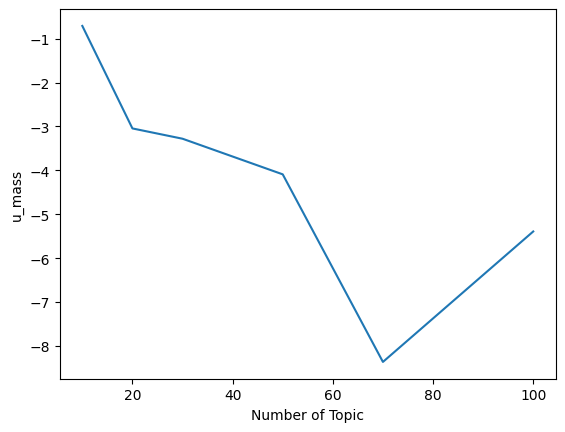

In [ ]:
list_out=[]
list_out2=[]
for i in [10,20,30,50,70,100]:
  lda_viz,c,c2=visualizeTopics(df['review'],i)
  list_out.append(c)
  list_out2.append(c2)
fig = plt.figure(figsize=(15, 5))
fig.suptitle('Coherence')

plt.plot([10,20,30,50,70,100],list_out)
plt.xlabel('Number of Topic')
plt.ylabel('u_mass')

plt.show()

In [ ]:
lda_viz,c,c2=visualizeTopics(df['review'],70)
lda_viz

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
41     0.242409 -0.048297       1        1  20.411675
49     0.273138  0.082588       2        1  15.362499
7      0.247542 -0.056393       3        1  10.144961
68     0.253411 -0.012299       4        1   7.157963
60     0.257863  0.058470       5        1   4.948468
...         ...       ...     ...      ...        ...
14    -0.223769 -0.002550      66        1   0.084213
62    -0.267763 -0.008729      67        1   0.072240
25    -0.287446 -0.017882      68        1   0.065669
31    -0.306446 -0.020137      69        1   0.057607
39    -0.285891 -0.009410      70        1   0.055306

[70 rows x 5 columns], topic_info=           Term           Freq          Total Category  logprob  loglift
81          the  194972.000000  194972.000000  Default  30.0000  30.0000
6           and  105864.000000  105864.000000  Default  29.0000  29.0000
58           of  100925.000000  100925.000000  Default  28.0000  28.0000
1             a   89400.000000   89400.000000  Default  27.0000  27.0000
86           to   90457.000000   90457.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
38481    mettle       8.004941       8.966056  Topic70  -5.4862   7.3867
29443  johnston       7.870702       8.816719  Topic70  -5.5031   7.3865
22631      solo      14.198530      21.743604  Topic70  -4.9131   7.0739
3012    awkward      13.952090      38.888100  Topic70  -4.9306   6.4750
41756     drake      10.404950      29.002946  Topic70  -5.2240   6.4749

[4180 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
0          1  0.078100         
0          2  0.277851         
0          3  0.035796         
0          4  0.068917         
0          5  0.088709         
...      ...       ...      ...
23484     67  0.901489     zack
16847      2  0.986940     zane
28497     65  0.957385  zealand
38005     33  0.959449    zeena
34612     70  0.963402    zorro

[15645 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[42, 50, 8, 69, 61, 66, 22, 5, 35, 53, 60, 6, 2, 55, 36, 57, 70, 17, 52, 9, 49, 45, 11, 54, 3, 46, 43, 19, 48, 58, 64, 39, 37, 34, 44, 59, 21, 1, 62, 28, 67, 51, 47, 56, 16, 18, 27, 65, 14, 20, 4, 38, 41, 68, 23, 25, 29, 31, 30, 33, 12, 7, 10, 24, 13, 15, 63, 26, 32, 40])

# Classification

In [35]:
df['class'].value_counts()

Negative    7000
Neutral     7000
Positive    7000
Name: class, dtype: int64

In [36]:
models_names=['logistic regression','RandomForest Classifier', 'naive base']
features_names=['TF_IDF','LDA']

In [37]:
def split_by(x,y,size):
    """
    Function : split_by
    Used to split data be persentage is given 
    ---------------------------------
    Input : x is train features data ,y label data,size split size
    ---------------------------------
    Output : X_train,X_test,y_train,y_test after split 
    """
    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=size,random_state=42,stratify=y)
    return X_train,X_test,y_train,y_test

In [38]:
def get_data(feature,x,y):
    """
    Function : get_data
    Used to split data and transform it be features engineering methods
    ---------------------------------
    Input : x is train features data ,y label data
    ---------------------------------
    Output : X_train,X_test,X_valid,y_train,y_test,y_valid,courpus  X_valid and y_valid are none if cross validation unused and courpus the dictionary of words 
    """

    X_tr,X_te,y_train,y_test_valid=split_by(x,y,0.2)
    if feature =='TF_IDF':
      X_train,X_test_valid,courpus = getTF_IDF_classification(X_tr,X_te)
    elif feature == 'LDA':
      X_train,X_test_valid,courpus = get_LDA(X_tr,X_te,70)
    X_test,X_valid,y_test,y_valid=split_by(X_test_valid,y_test_valid,0.5)
    return X_tr,X_train,X_test,X_valid,y_train,y_test,y_valid,courpus

In [39]:
def get_model(model_name):
    """
    Function : get_model
    Used to get model by given name 
    ---------------------------------
    Input : model_name
    ---------------------------------
    Output : model
    """
    if model_name=='logistic regression':
        model=LogisticRegression()
    elif model_name=='naive base':
        model = MultinomialNB()
    elif model_name=='RandomForest Classifier':
        model=RandomForestClassifier(max_depth=12)
    else:
        model=None
    return model

In [40]:
def Evaluate_by_Validation_Set(X_train,y_train,X_validation,y_validation,model):
    """
    Function : Evaluate_by_Validation_Set
    Used to evaluate the model by validation set
    splitting the data into train, test, validate
    ---------------------------------
    Input : X set, y set, model
    ---------------------------------
    Output : return the model accuracy after apply validation set
    """
    
    #fit the model on the train data
    model.fit(X_train, y_train)
    train_score=model.score(X_train, y_train)*100
    test_score=model.score(X_validation, y_validation)*100
    print("===============================================")
    print('train accuracy:',train_score)
    print('validation accuracy:',test_score)
    print("===============================================")
    ConfusionMatrixDisplay.from_estimator(model,X_validation, y_validation)  
    plt.show()
    print("***************************************************************************************")
    #return the model accuracy that applied on validation
    return train_score,test_score

In [73]:
def train(x,y,models_names,features_names):
    """
    Function : train
    Used to train the models that  by Cross Validation Method
    and shuffle data inside every fold to train model better
    ---------------------------------
    
    Input : x: is train features data 
            y: label data
            models_names: the names of models they are used in train
    ---------------------------------
    Output : the accuracies , models that were trained 
    """
    results={}
    models={}
    test_data={}
    for feature in features_names:
      org_data,X_train,X_test,X_validation,y_train,y_test,y_validation,courpus=get_data(feature,x,y)
      for model_name in models_names:
          name=feature+' with '+model_name
          print('training using {} and {} '.format(feature,model_name))
          model=get_model(model_name)
          train,accuracy=Evaluate_by_Validation_Set(X_train,y_train,X_validation,y_validation,model)
          results[name]=[train,accuracy]
          models[name]=model
          test_data[name]=[org_data,X_test,y_test,courpus]
    return results,test_data,models

training using TF_IDF and logistic regression 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


train accuracy: 84.94047619047619
validation accuracy: 66.76190476190477


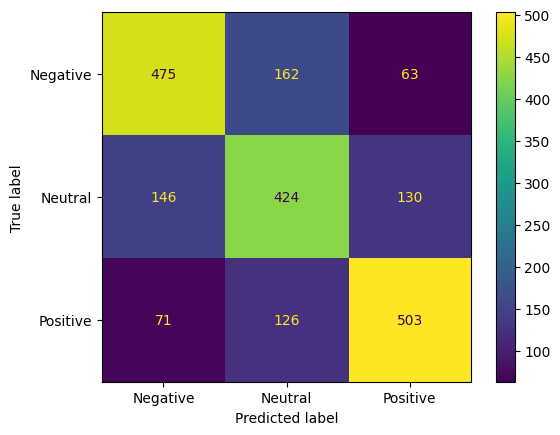

***************************************************************************************
training using TF_IDF and RandomForest Classifier 
train accuracy: 74.60714285714286
validation accuracy: 56.285714285714285


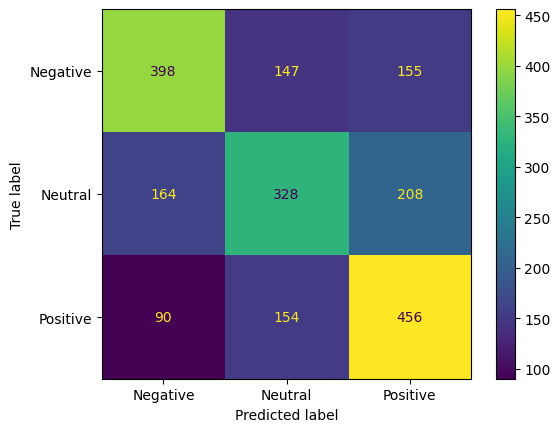

***************************************************************************************
training using TF_IDF and naive base 
train accuracy: 83.01190476190476
validation accuracy: 61.09523809523809


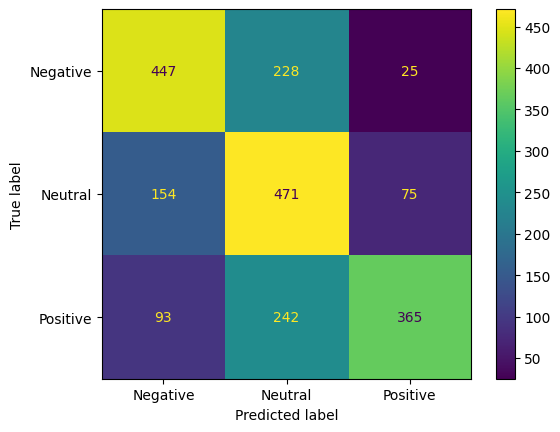

***************************************************************************************
training using LDA and logistic regression 


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"


train accuracy: 43.98809523809524
validation accuracy: 43.904761904761905


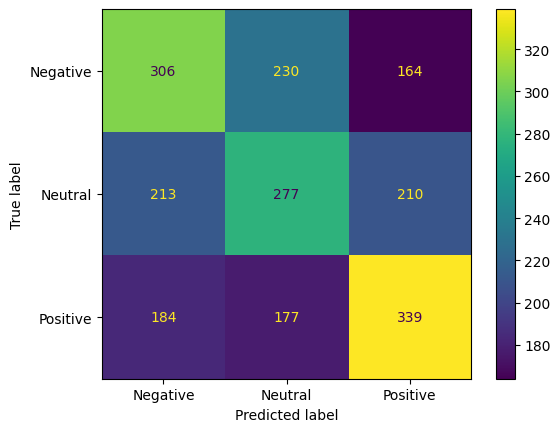

***************************************************************************************
training using LDA and RandomForest Classifier 


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


train accuracy: 67.69047619047619
validation accuracy: 43.714285714285715


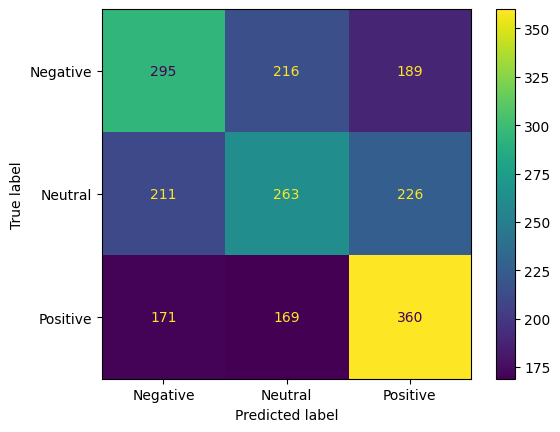

***************************************************************************************
training using LDA and naive base 
train accuracy: 43.738095238095234
validation accuracy: 43.476190476190474


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  "X does not have valid feature names, but"


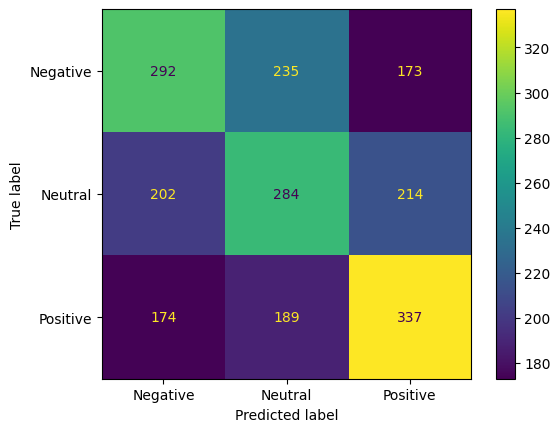

***************************************************************************************


In [74]:
data,test_set,models=train(df['review'],df['class'],models_names,features_names)

### Save champain model

In [43]:
models['TF_IDF with logistic regression']

LogisticRegression()

In [44]:
filename = '/content/drive/MyDrive/finalized_model.sav'
pickle.dump(models['TF_IDF with logistic regression'], open(filename, 'wb'))


In [45]:
pickle.dump(test_set['TF_IDF with logistic regression'][3], open("tfidf.pickle", "wb"))
pickle.dump(test_set['TF_IDF with logistic regression'][0], open("train_comment_features.pickle", "wb"))


In [46]:
def plotCompare(Features_Engneering_names,models_names,results,x_ax):
  num_plots =len(Features_Engneering_names)*len(models_names)
  total_cols = len(models_names)
  total_rows = len(Features_Engneering_names)

  fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                          figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
  fig.suptitle('compering between models',fontweight="bold",size=42)

  for i, var in enumerate(results.keys()):
      row = i//total_cols
      pos = i % total_cols
      plt.figure(figsize=(12,5))
      d=[]
      value=results[var]
      for v in value:
        d.append(v)
      
      
      axs[row, pos].set_title(var, size=26)
      g = sns.barplot(x=x_ax, y=d,ax=axs[row][pos])
      counter=0
      for va in value:
        if counter==0 or counter ==3:
          v=round(va,2)
        else:
          v=str(round(va,2))+' %'
        g.text(counter,va,v, color='black', ha="center")
        counter+=1
  plt.show()




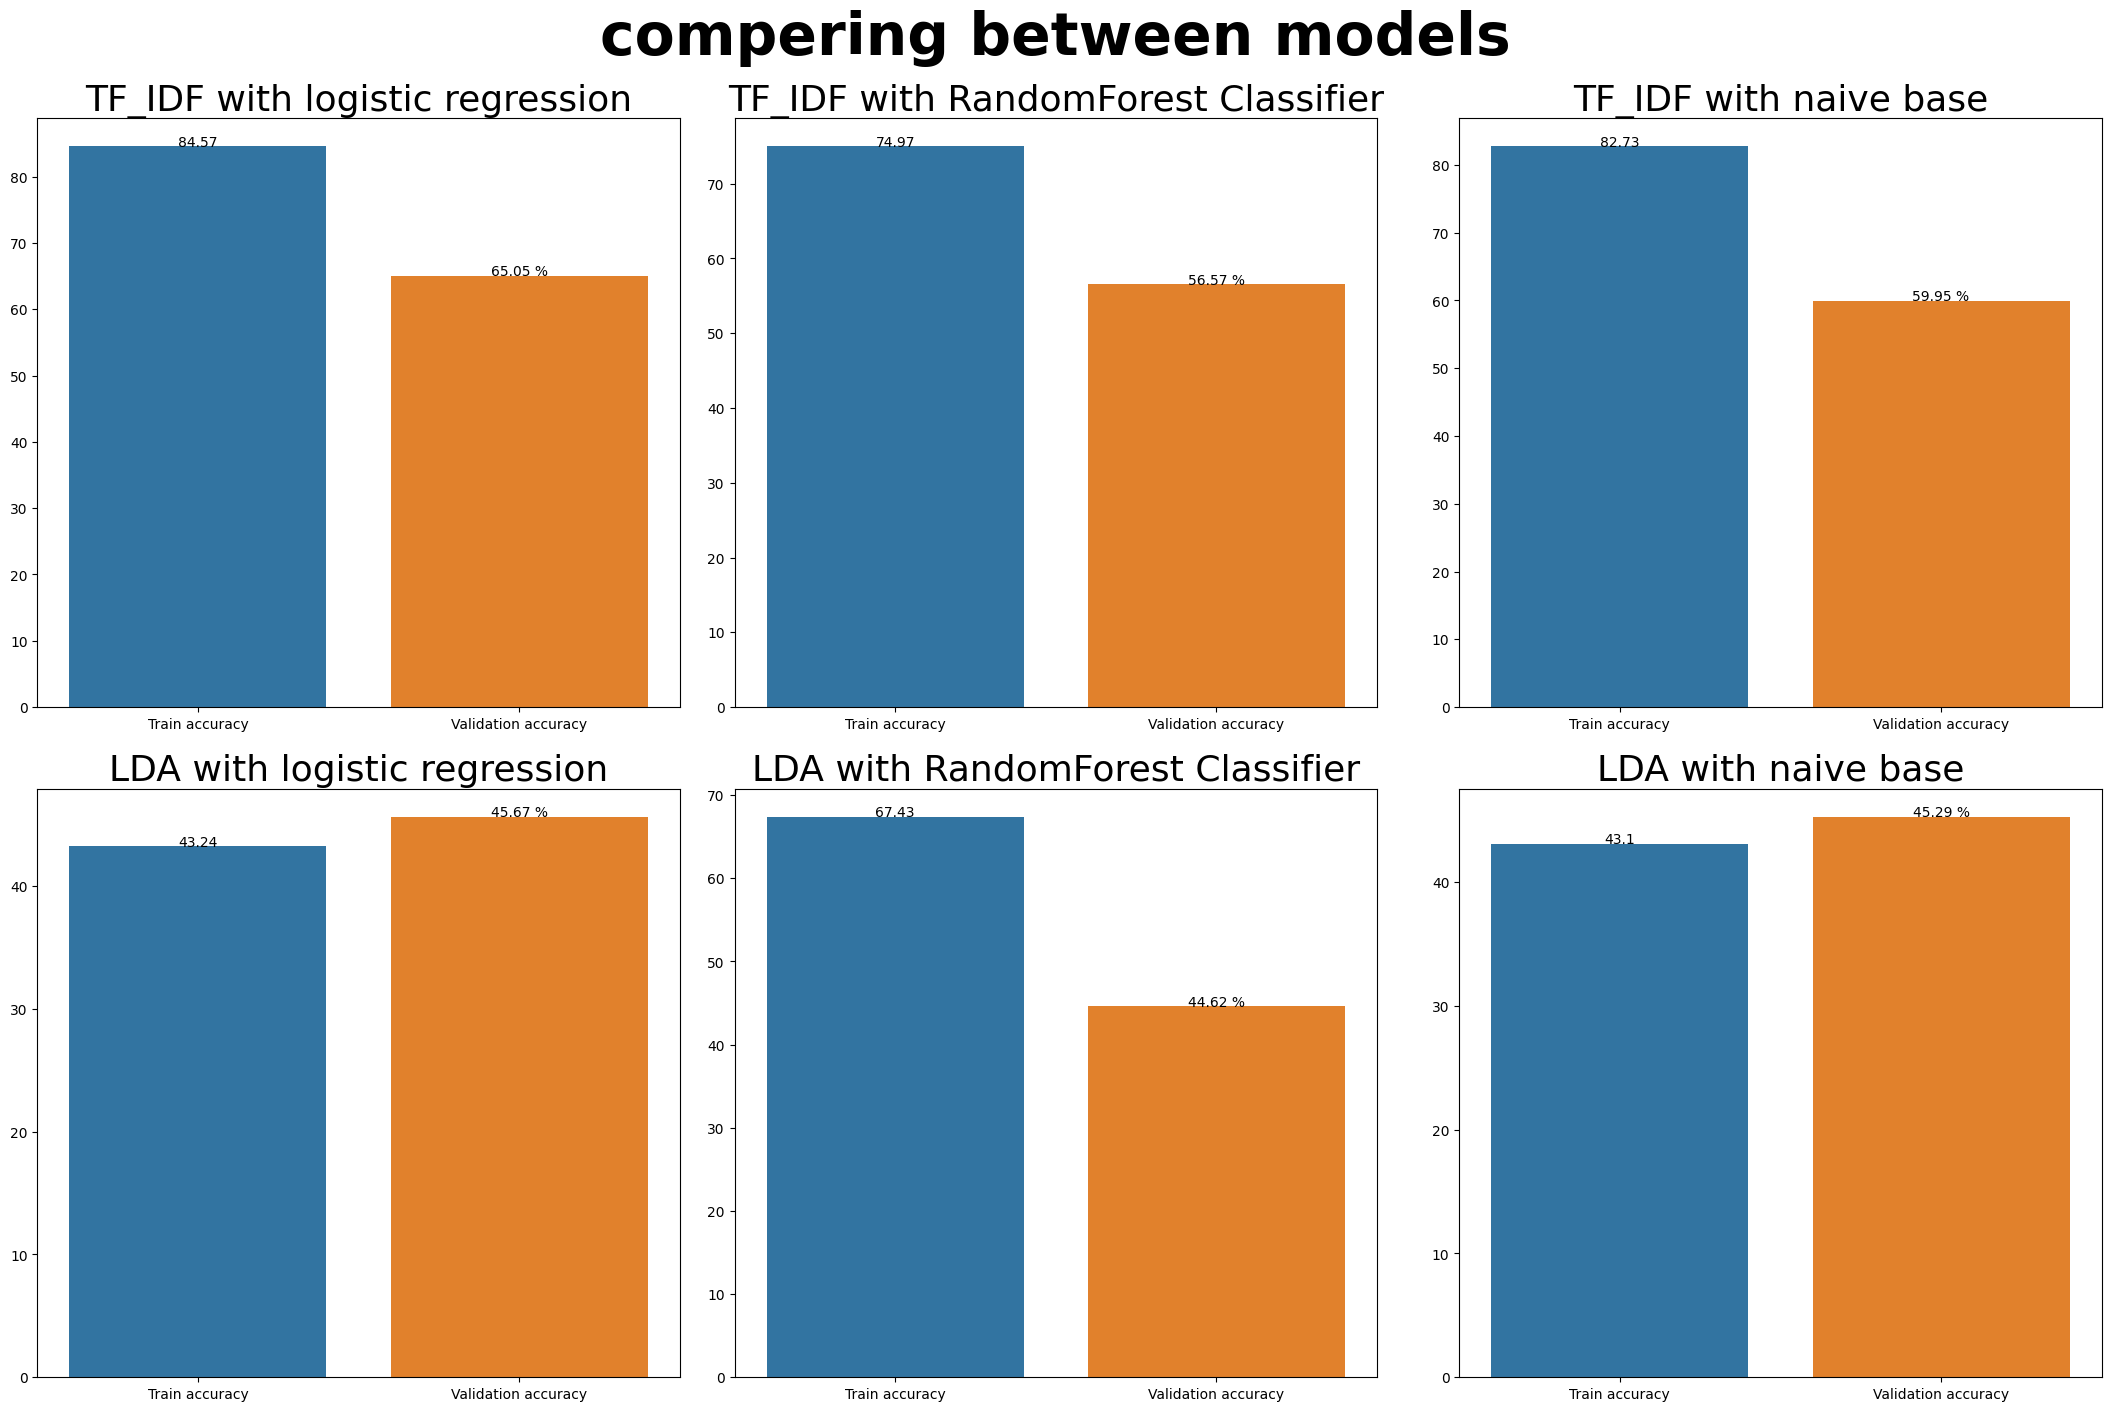

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

In [ ]:
plotCompare(features_names,models_names,data,['Train accuracy','Validation accuracy'])

In [47]:
y_pred_TF_IDF_LG=models['TF_IDF with logistic regression'].predict(test_set['TF_IDF with logistic regression'][1])
y_pred_TF_IDF_LG

array(['Negative', 'Neutral', 'Positive', ..., 'Positive', 'Neutral',
       'Neutral'], dtype=object)

## Error analysis

In [52]:
def printWrongPoints(X_test,y_test,y_pred,labels,courpus):
    """print the Wrong partitions of predictions
    Input: model, X_test, y_test, y_pred
    Output: print the Wrong partitions of prediction
    """
    print_wordCloud_couter=0
    wrongPoints = []
    wrongPointsIndex = []
     
    for index, val in enumerate(X_test):
        if y_pred[index] !=y_test[index]:
            print_wordCloud_couter+=1
            pred_wrong=(courpus.inverse_transform(val))        
            wrongPoints.append(pred_wrong)
            wrongPointsIndex.append(y_pred[index])
            text = " ".join(str(v) for v in pred_wrong)
            if print_wordCloud_couter<=10:
              # Creating word_cloud with text as argument in .generate() method
              wc = WordCloud(collocations = False, background_color = 'white').generate(text)
              # Display the generated Word Cloud
              plt.imshow(wc, interpolation='bilinear')
              plt.axis("off")
              plt.show()
            
       
    
    booksDataframeResult = pd.DataFrame(data=pd.Series(data=wrongPoints),columns=['Partitions' ]) 
     
    for i in range(len(labels)):
        booksDataframeResult[labels[i]]= [np.full(len(wrongPoints), [' '],dtype=str)][0] 
    

    classesWrongPredictionCounts=np.zeros(len(labels),dtype =int)
    print(classesWrongPredictionCounts)
    for index, val in enumerate(wrongPoints):
        booksDataframeResult.at[index,wrongPointsIndex[index]]='--X--'

   
     
    
    print("\n\n******\n\nWrong Predictions\n\n")
    # display(booksDataframeResult)

    return booksDataframeResult,wrongPoints

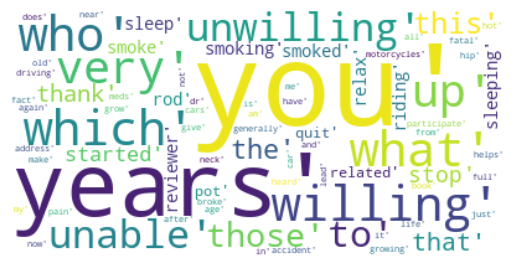

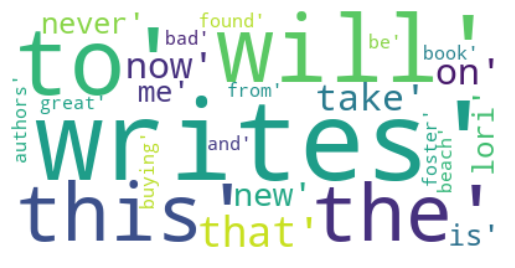

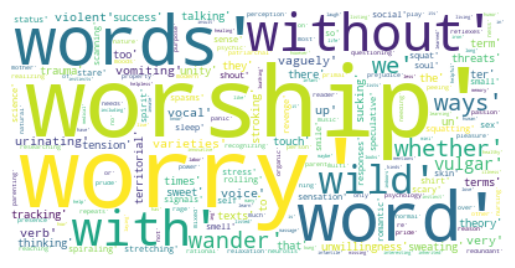

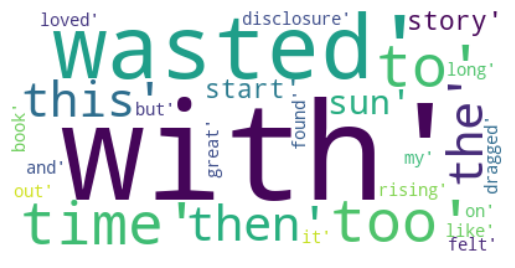

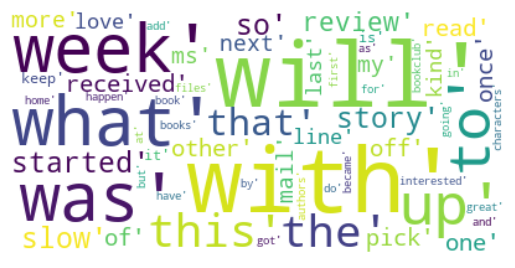

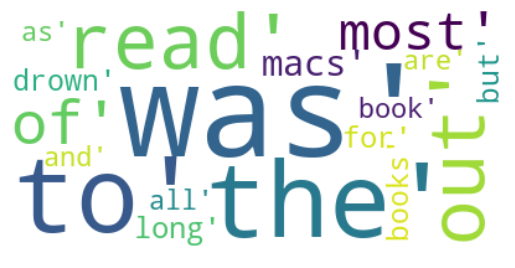

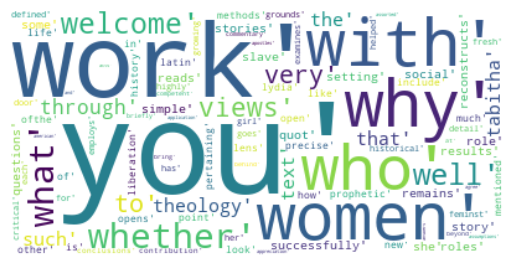

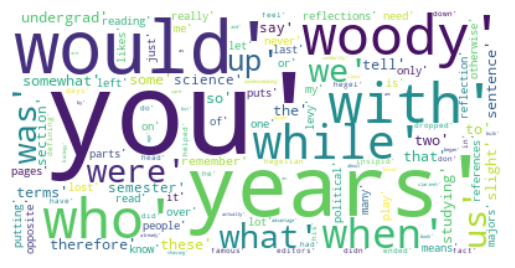

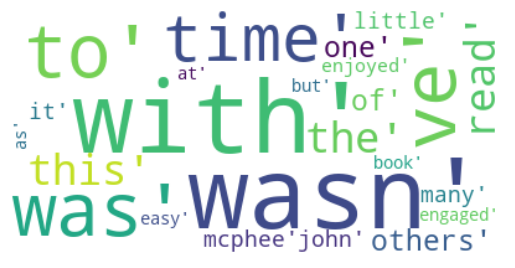

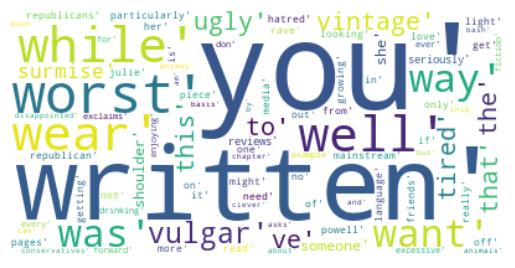

[0 0 0]


******

Wrong Predictions




In [53]:
pbooksDataframeResult,wrongPoints=printWrongPoints(test_set['TF_IDF with logistic regression'][1],test_set['TF_IDF with logistic regression'][2].values,y_pred_TF_IDF_LG,['Negative','Neutral','Negative'],test_set['TF_IDF with logistic regression'][3])

In [68]:
type(wrongPoints)

list

In [71]:
flat_list = []
for sublist in wrongPoints:
    for item in sublist:
        flat_list.append(item)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

<Figure size 1500x1000 with 0 Axes>

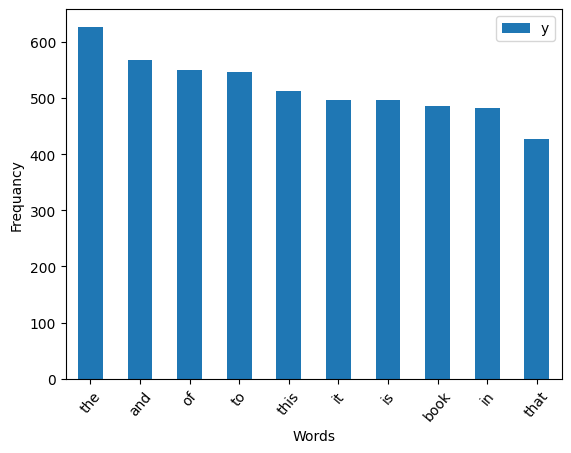

In [72]:
vocab = Counter()

for token in flat_list:
    print(type(token))
    vocab.update(token)
mostc=vocab.most_common(10)

plt.figure(figsize=(15,10))

pd.DataFrame(mostc,columns=['x','y']).plot.bar(x='x', rot=0)
plt.xticks(rotation=50)
plt.xlabel("Words")
plt.ylabel("Frequancy")
plt.show()


